## 1. Load saved logits, masks, and images

In [1]:
import torch

def load_logits_masks_images(path):
    data = torch.load(path)
    logits = data["logits"]
    masks = data["masks"]
    images = data["images"]
    probs = torch.softmax(logits, dim=1)
    return logits, probs, masks, images

calib_logits, calib_probs, calib_masks, _ = load_logits_masks_images("calibration_logits.pth")
test_logits, test_probs, test_masks, test_images = load_logits_masks_images("test_logits.pth")

/tmp/ipykernel_192915/2668261180.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


## 2. Compute nonconformity scores for the calibration set

In [5]:
def compute_nonconformity(probs, masks):
    """
    probs: (N, C, H, W)
    masks: (N, H, W)
    """
    idx = masks.unsqueeze(1)
    true_class_probs = torch.gather(probs, 1, idx)
    nonconformity_scores = 1 - true_class_probs.squeeze(1)
    return nonconformity_scores.flatten()

nonconformity_scores_calib = compute_nonconformity(calib_probs, calib_masks)
print("Nonconformity scores computed for calibration set!")

Nonconformity scores computed for calibration set!


##  3. Compute p-values for the test set

In [9]:
import numpy as np

# 1️⃣ Subsample calibration set
def subsample_calibration(nonconformity_scores, sample_frac=0.01):
    total_pixels = nonconformity_scores.shape[0]
    sample_size = int(sample_frac * total_pixels)
    indices = np.random.choice(total_pixels, size=sample_size, replace=False)
    return nonconformity_scores[indices]

# 2️⃣ Histogram-based p-value computation
def compute_p_values_histogram(test_probs, nonconformity_scores_calib, num_bins=1000):
    N, C, H, W = test_probs.shape
    p_values = torch.zeros_like(test_probs)

    # Build histogram of calibration scores
    calib_scores = nonconformity_scores_calib.numpy()
    hist, bin_edges = np.histogram(calib_scores, bins=num_bins, range=(0, 1), density=False)
    cum_counts = np.cumsum(hist[::-1])[::-1]  # cumulative counts from highest to lowest
    bin_width = bin_edges[1] - bin_edges[0]
    total_calib = len(calib_scores)

    for c in range(C):
        print(f"Computing p-values for class {c} (histogram-based)...")
        score_c = (1 - test_probs[:, c, :, :]).flatten().cpu().numpy()

        # Determine bin index for each score
        bin_indices = np.clip(((score_c - bin_edges[0]) / bin_width).astype(int), 0, num_bins - 1)
        p_vals = cum_counts[bin_indices] / total_calib

        p_values[:, c, :, :] = torch.tensor(p_vals.reshape(N, H, W))

    return p_values

# Subsample (1% for even faster results)
nonconformity_scores_calib_sub = subsample_calibration(nonconformity_scores_calib, sample_frac=0.01)
print(f"Subsampled calibration set size: {len(nonconformity_scores_calib_sub)}")

# Compute p-values with histogram approximation
print("Computing p-values with histogram-based approximation...")
p_values_hist = compute_p_values_histogram(test_probs, nonconformity_scores_calib_sub, num_bins=1000)
print("P-values computed (histogram)!")

Subsampled calibration set size: 262906
Computing p-values with histogram-based approximation...
Computing p-values for class 0 (histogram-based)...
Computing p-values for class 1 (histogram-based)...
Computing p-values for class 2 (histogram-based)...
Computing p-values for class 3 (histogram-based)...
P-values computed (histogram)!


## 4. Define prediction set and fallback

In [14]:
import torch
import numpy as np
from sklearn.metrics import f1_score

alpha = 0.1  # Confidence level (e.g., 90%)
prediction_set = p_values_hist > alpha  # (N, C, H, W)

# Vectorized final class decision
def decide_final_class_vectorized(test_probs, prediction_set):
    N, C, H, W = test_probs.shape
    pred_final = torch.full((N, H, W), -1, dtype=torch.long)

    # Count how many classes are in the prediction set
    num_candidates = prediction_set.sum(dim=1)

    # Convert boolean to int for argmax
    prediction_set_int = prediction_set.int()

    # Where only one candidate → assign that class
    only_one_mask = num_candidates == 1
    only_one_idx = prediction_set_int.argmax(dim=1)
    pred_final[only_one_mask] = only_one_idx[only_one_mask]

    # For others → fallback to baseline (argmax of probabilities)
    fallback_mask = pred_final == -1
    fallback_preds = test_probs.argmax(dim=1)
    pred_final[fallback_mask] = fallback_preds[fallback_mask]

    return pred_final


print("Deciding final label for each pixel (vectorized)...")
pred_final = decide_final_class_vectorized(test_probs, prediction_set)

Deciding final label for each pixel (vectorized)...


## 5. Final evaluation

In [16]:
# Baseline predictions (simple argmax of probabilities)
baseline_preds = test_probs.argmax(dim=1)  # (N, H, W)

# Evaluation function
def compute_f1(preds, masks, num_classes=4):
    preds = preds.cpu().numpy().flatten()
    masks = masks.cpu().numpy().flatten()
    f1_macro = f1_score(masks, preds, average='macro', zero_division=0)
    f1_per_class = f1_score(masks, preds, average=None, labels=list(range(num_classes)))
    return f1_macro, f1_per_class

# Evaluate baseline
f1_macro_baseline, f1_per_class_baseline = compute_f1(baseline_preds, test_masks)

print("\n=== Baseline Evaluation (argmax only) ===")
print(f"F1 Macro: {f1_macro_baseline:.3f}")
for c, f1 in enumerate(f1_per_class_baseline):
    print(f"Class {c}: F1 = {f1:.3f}")

# Evaluate conformal (already computed)
f1_macro_conformal, f1_per_class_conformal = compute_f1(pred_final, test_masks)

print("\n=== Conformal Prediction Evaluation (with fallback) ===")
print(f"F1 Macro: {f1_macro_conformal:.3f}")
for c, f1 in enumerate(f1_per_class_conformal):
    print(f"Class {c}: F1 = {f1:.3f}")



=== Baseline Evaluation (argmax only) ===
F1 Macro: 0.750
Class 0: F1 = 0.991
Class 1: F1 = 0.929
Class 2: F1 = 0.668
Class 3: F1 = 0.411

=== Conformal Prediction Evaluation (with fallback) ===
F1 Macro: 0.750
Class 0: F1 = 0.991
Class 1: F1 = 0.929
Class 2: F1 = 0.668
Class 3: F1 = 0.411


## 6. Plot

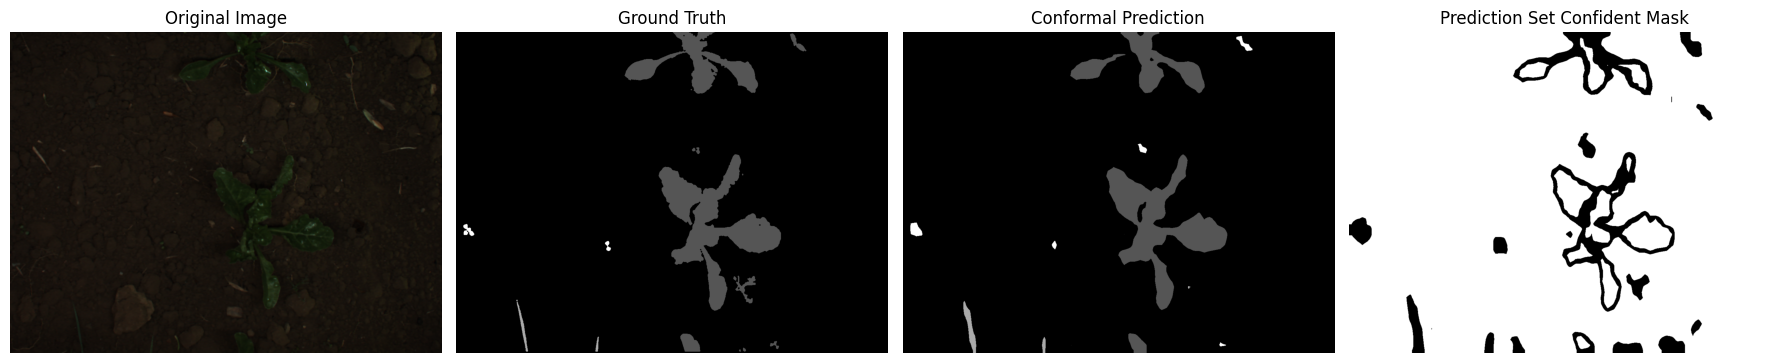

In [17]:
import matplotlib.pyplot as plt

# Determine "conformal confident mask"
N, C, H, W = prediction_set.shape
num_candidates = prediction_set.sum(dim=1)
confident_mask = num_candidates == 1  # True where prediction set has exactly 1 class
confident_mask = confident_mask.cpu().numpy()

# Visualize for a single image
image_idx = 0  # Change index to see other images

plt.figure(figsize=(18, 5))

# 1️⃣ Original image (RGB)
img = test_images[image_idx][:3].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# 2️⃣ Ground truth mask
plt.subplot(1, 4, 2)
plt.imshow(test_masks[image_idx].cpu().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# 3️⃣ Conformal prediction final
plt.subplot(1, 4, 3)
plt.imshow(pred_final[image_idx].cpu().numpy(), cmap='gray', vmin=0, vmax=3)
plt.title("Conformal Prediction")
plt.axis('off')

# 4️⃣ Confident mask (where Conformal trusted the prediction set)
plt.subplot(1, 4, 4)
plt.imshow(confident_mask[image_idx], cmap='gray')
plt.title("Prediction Set Confident Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


## 7. Coverage of Image

In [18]:
coverage = confident_mask.mean()
print(f"Coverage (proportion of confident pixels): {coverage:.3%}")


Coverage (proportion of confident pixels): 90.324%


## 8. Risk

In [19]:
# 1️⃣ Coverage (proportion of pixels confidently classified by Conformal)
coverage = confident_mask.mean()
print(f"Coverage (proportion of confident pixels): {coverage:.3%}")

# 2️⃣ Selective Risk: error only on confident pixels (Conformal)
def compute_selective_risk(preds, masks, confident_mask):
    preds_flat = preds.cpu().numpy().flatten()
    masks_flat = masks.cpu().numpy().flatten()
    confident_flat = confident_mask.flatten()

    correct = (preds_flat == masks_flat)
    selective_risk = 1 - correct[confident_flat].mean()
    return selective_risk

selective_risk = compute_selective_risk(pred_final, test_masks, confident_mask)
print(f"Selective Risk (error on confident pixels): {selective_risk:.3%}")

# 3️⃣ Baseline global error (baseline risk on all pixels)
baseline_preds = test_probs.argmax(dim=1)
baseline_preds_flat = baseline_preds.cpu().numpy().flatten()
masks_flat = test_masks.cpu().numpy().flatten()
global_risk_baseline = 1 - (baseline_preds_flat == masks_flat).mean()
print(f"Global Risk (baseline error on all pixels): {global_risk_baseline:.3%}")


Coverage (proportion of confident pixels): 90.324%
Selective Risk (error on confident pixels): 0.037%
Global Risk (baseline error on all pixels): 1.681%
